In [1]:
# Import dependencies
from scipy.io import wavfile
from sklearn.svm import SVC
from scipy.signal import spectrogram
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from pathlib import Path

import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
#assert tf.__version__ == "1.7.0"
tf.logging.set_verbosity(tf.logging.INFO)


In [2]:
dataset = [{'path': path, 'label': path.split('/' )[5][8:14] } for path in glob.glob("/Users/apt/Desktop/Data/dataset/**/*.wav")]
df = pd.DataFrame.from_dict(dataset)

# Add a column to store the data read from each wavfile...   
df['x'] = df['path'].apply(lambda x: wavfile.read(x)[1])
df.head()

,label,path,x
0,extsys,/Users/apt/Desktop/Data/dataset\extsys\127_130...,"[873, 843, 762, 636, 577, 690, 639, 515, 470, ..."
1,extsys,/Users/apt/Desktop/Data/dataset\extsys\128_130...,"[747, 485, 363, 195, 26, -2, 82, 172, 279, 379..."
2,extsys,/Users/apt/Desktop/Data/dataset\extsys\130_130...,"[-688, -666, -618, -387, -488, -433, -325, -23..."
3,extsys,/Users/apt/Desktop/Data/dataset\extsys\134_130...,"[182, 46, 227, 36, 14, 222, 36, -12, 59, -33, ..."
4,extsys,/Users/apt/Desktop/Data/dataset\extsys\138_130...,"[677, 722, 381, 235, -85, -25, 92, -175, -273,..."


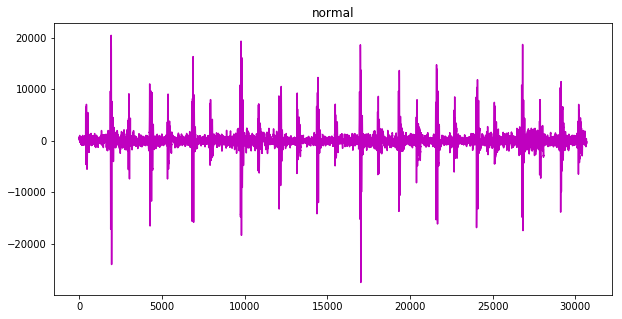

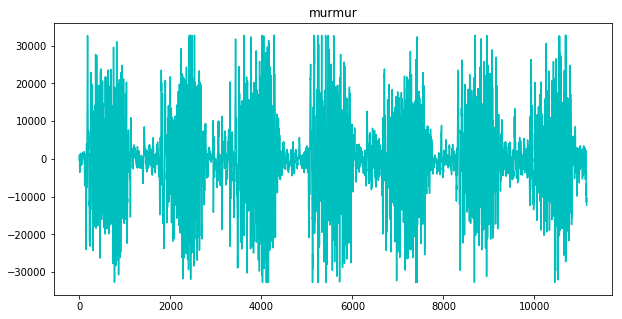

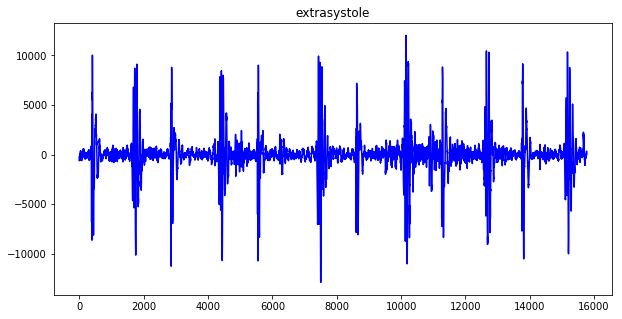

In [3]:
#Choosing one of the each samples form each catogery 
normal = df[df['label'] == 'normal' ].sample(1)
murmur = df[df['label'] == 'murmur' ].sample(1)
extrasystole = df[df['label'] == 'extsys' ].sample(1)

# Plot the three samples onto three different figures
plt.figure(1, figsize=(10,5))
plt.title('normal')
plt.plot(normal['x'].values[0], c='m')

plt.figure(2, figsize=(10, 5))
plt.title('murmur')
plt.plot(murmur['x'].values[0], c='c')

plt.figure(3, figsize=(10, 5))
plt.title('extrasystole')
plt.plot(extrasystole['x'].values[0], c='b')

In [4]:
#make the lenght of all audio files same by repeating audio file contents till its length is equal to max length audio file
max_length = max(df['x'].apply(len))

# Kaggle: What's in a heartbeat? - Peter Grenholm
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = np.float32)
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

df['x'] = df['x'].apply(repeat_to_length, length=max_length)
df.head()

,label,path,x
0,extsys,/Users/apt/Desktop/Data/dataset\extsys\127_130...,"[873.0, 843.0, 762.0, 636.0, 577.0, 690.0, 639..."
1,extsys,/Users/apt/Desktop/Data/dataset\extsys\128_130...,"[747.0, 485.0, 363.0, 195.0, 26.0, -2.0, 82.0,..."
2,extsys,/Users/apt/Desktop/Data/dataset\extsys\130_130...,"[-688.0, -666.0, -618.0, -387.0, -488.0, -433...."
3,extsys,/Users/apt/Desktop/Data/dataset\extsys\134_130...,"[182.0, 46.0, 227.0, 36.0, 14.0, 222.0, 36.0, ..."
4,extsys,/Users/apt/Desktop/Data/dataset\extsys\138_130...,"[677.0, 722.0, 381.0, 235.0, -85.0, -25.0, 92...."


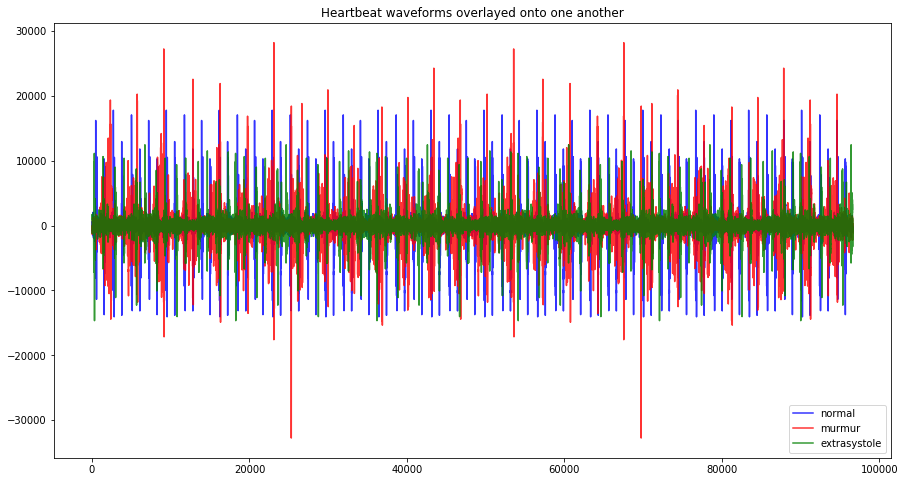

In [5]:
# Collect one sample from each of the three classes and plot their waveforms
normal = df[df['label'] == 'normal' ].sample(1)
murmur = df[df['label'] == 'murmur' ].sample(1)
extrasystole = df[df['label'] == 'extsys' ].sample(1)

plt.figure(1, figsize=(15,8))
plt.plot(normal['x'].values[0], c='b', label='normal', alpha=0.8)
plt.plot(murmur['x'].values[0], c='r', label='murmur', alpha=0.8)
plt.plot(extrasystole['x'].values[0], c='g', label='extrasystole', alpha=0.8)

plt.title('Heartbeat waveforms overlayed onto one another')
plt.legend(loc='lower right')
# plt.savefig('temp.png')

Text(0.5,0,'Time [sec]')

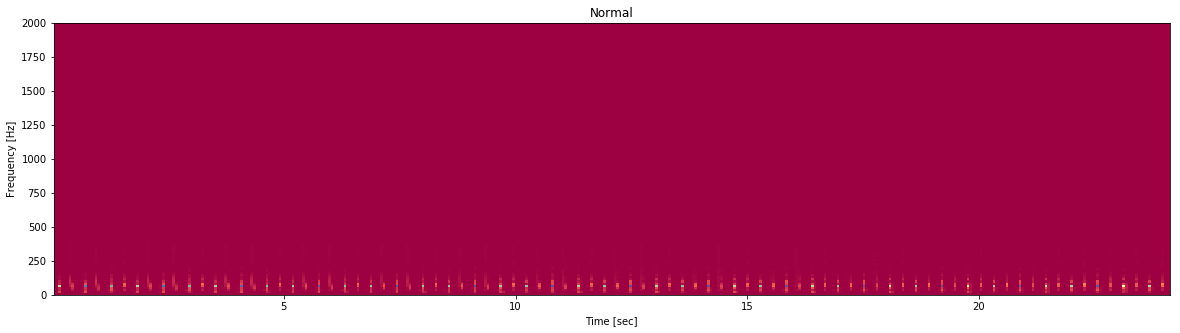

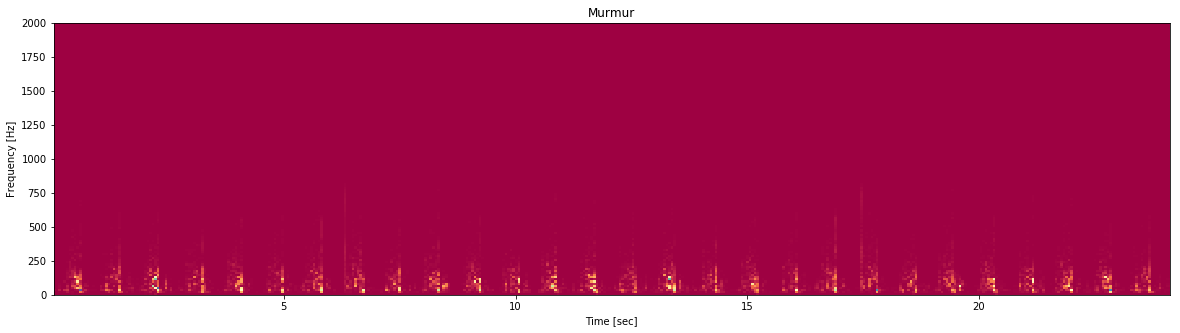

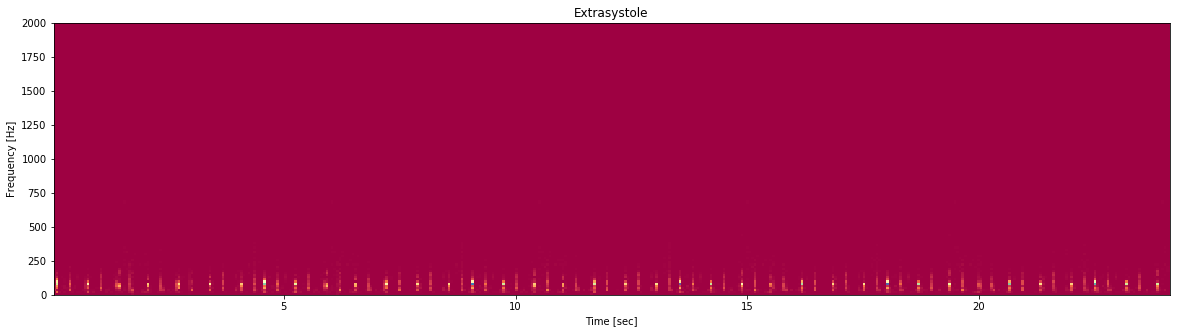

In [6]:
fs = 4000
f_normal, t_normal, Sxx_normal = spectrogram(normal['x'].values[0], 4000)
plt.figure(1, figsize=(20,5))
plt.title('Normal')
plt.pcolormesh(t_normal, f_normal, Sxx_normal, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

f_murmur, t_murmur, Sxx_murmur = spectrogram(murmur['x'].values[0], 4000)
plt.figure(2, figsize=(20, 5))
plt.title('Murmur')
plt.pcolormesh(t_murmur, f_murmur, Sxx_murmur, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

f_extra, t_extra, Sxx_extra = spectrogram(extrasystole['x'].values[0], 4000)
plt.figure(3, figsize=(20, 5))
plt.title('Extrasystole')
plt.pcolormesh(t_extra, f_extra, Sxx_extra, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [7]:
# Put the data into numpy arrays. Most machine learning libraries use numpy arrays.
x = np.stack(df['x'].values, axis=0)
y = np.stack(df['label'].values, axis=0)

In [8]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(x, df['label'].values, df['path'].values, test_size=0.20)
print("x_train: {0}, x_test: {1}".format(x_train.shape, x_test.shape))

x_train: (249, 96640), x_test: (63, 96640)


In [9]:
clf = SVC()
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("Accuracy %.3f" % accuracy_score(y_test, predictions))

Accuracy 0.698


In [10]:
clf = MLPClassifier(hidden_layer_sizes=(1024,512,256,128,), 
                    max_iter=5000, verbose=True)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("Accuracy %.3f" % accuracy_score(y_test, predictions))

Iteration 1, loss = 16.36908819
Iteration 2, loss = 7.70325582
Iteration 3, loss = 4.21927125
Iteration 4, loss = 0.92640590
Iteration 5, loss = 1.20395436
Iteration 6, loss = 0.64923438
Iteration 7, loss = 0.00203146
Iteration 8, loss = 0.00213094
Iteration 9, loss = 0.18716574
Iteration 10, loss = 0.27971619
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Accuracy 0.444


In [11]:
# Convert data to the format tf.keras expects
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_train.shape

(249, 96640, 1)

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.GlobalAvgPool1D())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
# Need to convert y labels into one-hot encoded vectors
y_train_int_categories, y_train_class_names = pd.factorize(y_train)
print("y_train_class_names: {0}".format(y_train_class_names))

y_test_int_categories, y_test_class_names = pd.factorize(y_test)
print("y_test_class_names: {0}".format(y_test_class_names))
y_train_hot = tf.keras.utils.to_categorical(y_train_int_categories)
y_test_hot = tf.keras.utils.to_categorical(y_test_int_categories)

hist = model.fit(x_train, y_train_hot, 
                 epochs=30,
                 validation_data=(x_test, y_test_hot))

y_train_class_names: ['extsys' 'normal' 'murmur']
y_test_class_names: ['normal' 'extsys' 'murmur']
Train on 249 samples, validate on 63 samples
Epoch 1/30
249/249 [==============================] - 25s 99ms/step - loss: 1.1620 - acc: 0.3976 - val_loss: 1.6857 - val_acc: 0.1746
Epoch 2/30
249/249 [==============================] - 20s 79ms/step - loss: 1.0751 - acc: 0.4980 - val_loss: 1.0810 - val_acc: 0.1746
Epoch 3/30
249/249 [==============================] - 20s 80ms/step - loss: 0.9315 - acc: 0.5783 - val_loss: 1.2250 - val_acc: 0.1746
Epoch 4/30
249/249 [==============================] - 19s 78ms/step - loss: 0.9059 - acc: 0.6024 - val_loss: 1.2713 - val_acc: 0.1746
Epoch 5/30
249/249 [==============================] - 20s 79ms/step - loss: 0.8836 - acc: 0.6305 - val_loss: 1.0794 - val_acc: 0.2063
Epoch 6/30
249/249 [==============================] - 20s 79ms/step - loss: 0.8118 - acc: 0.6908 - val_loss: 1.1443 - val_acc: 0.1746
Epoch 7/30
249/249 [==============================] 

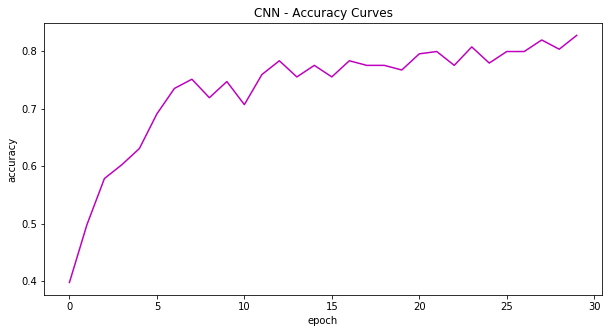

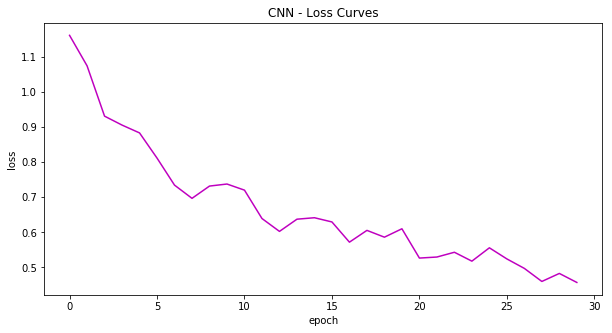

In [15]:
accuracy = hist.history['acc']
loss = hist.history['loss']

plt.figure(1, figsize=(10, 5))
plt.title('CNN - Accuracy Curves')
plt.plot(accuracy, c='m')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.figure(2, figsize=(10, 5))
plt.title('CNN - Loss Curves')
plt.plot(loss, c='m')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()


In [16]:
import time
start = time.time()*1000
model.predict(x_test)
end = time.time()*1000
total = end - start
print("Total prediction time (milliseconds) for %d samples: %f" % (len(x_test), total))
print("Average prediction time for one example: %f" % (total/len(x_test)))

Total prediction time (milliseconds) for 63 samples: 2421.629639
Average prediction time for one example: 38.438566


In [24]:
# Save the train model
tf.keras.models.save_model(
    model,
    filepath='C:/Users/apt/Desktop/save_model',
    overwrite=True,
    include_optimizer=True
)